In [1]:
import pytensor
#pytensor.config.cxx = ""

In [2]:
# Load Real Data
import pandas as pd

hii_data = pd.read_csv("hii_data.csv")

In [3]:
print(hii_data)

                gname       glong      glat    radius  vlsr  e_vlsr  \
0     G000.335-00.016    0.335364 -0.015004   42.5002  14.0     0.3   
1     G000.492+00.191    0.492402  0.191645   42.5000  -7.5     0.1   
2     G000.528+00.180    0.528170  0.180976   25.6720  -2.3     1.1   
3     G000.573-00.855    0.573000 -0.855000  149.5120  14.2     0.1   
4     G000.583-00.868    0.583828 -0.868000   49.5116  14.2     0.1   
...               ...         ...       ...       ...   ...     ...   
1890  G358.397-00.861  358.397000 -0.860381  261.3700   5.3     0.1   
1891  G358.633+00.062  358.633000  0.062001   42.5000  13.8     0.3   
1892  G358.641-00.539  358.641000 -0.538599  497.4720  -2.6     1.3   
1893  G358.881+00.057  358.881000  0.057693   55.8324  -7.0     0.5   
1894  G359.956-00.506  359.956000 -0.505211  165.8700  15.0     0.1   

            line     e_line line_unit      beam_area  ...  telescope  kdar  \
0      65.960000   0.680000  mJy/beam    6893.719776  ...        GBT 

In [4]:
data = hii_data.iloc[123].copy()

print(data)

gname                  G011.035+00.065
glong                          11.0351
glat                          0.065883
radius                         42.5002
vlsr                              12.1
e_vlsr                             0.1
line                             21.88
e_line                           0.176
line_unit                     mJy/beam
beam_area                  6893.719776
line_freq                       8000.0
fwhm                              28.6
e_fwhm                             0.3
te                                 NaN
e_te                             500.0
source                    WISE Catalog
author          Anderson et al. (2011)
telescope                          GBT
kdar                               NaN
Rgal                          6.523202
near                          1.669856
far                          14.323675
tangent                        8.01436
vlsr_tangent                104.164034
plx                                NaN
dist_author              

In [5]:
from physiokinematic import model
import importlib
importlib.reload(model)
pkmodel = model.model

In [6]:
# setup model
my_model = pkmodel(data)

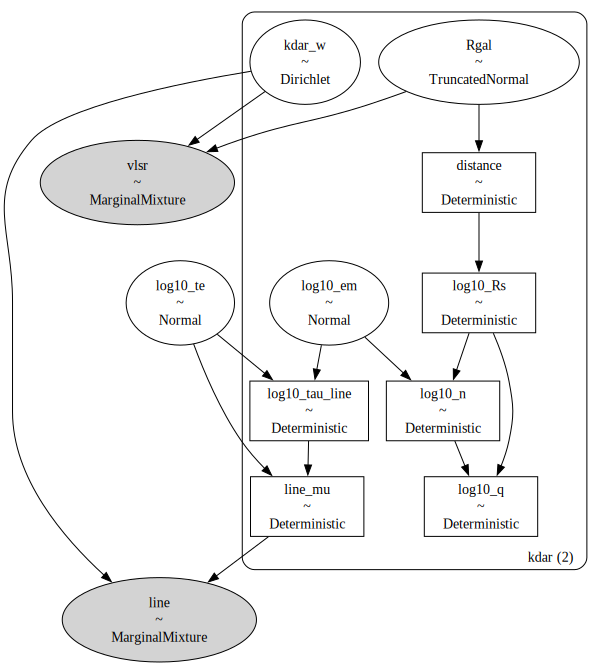

In [7]:
# visualize model
my_model.to_graphviz()

In [8]:
import pymc as pm

# sample prior predictive
with my_model:
    prior = pm.sample_prior_predictive(1000)

Sampling: [Rgal, kdar_w, line, log10_em, log10_te, vlsr]


/tmp/ipykernel_831527/3376056640.py:6: RuntimeWarning: invalid value encountered in log10
  ax.hist(np.log10(prior.prior_predictive["line"].data.flatten()), bins=20, color="gray", edgecolor="k", alpha=0.5)


Text(0.5, 0, 'log$_{10}$ Line (mJy beam$^{-1}$)')

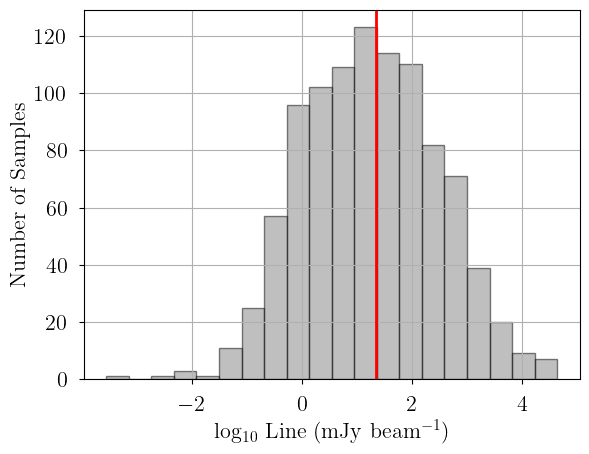

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# plot prior predictive samples
fig, ax = plt.subplots()
ax.hist(np.log10(prior.prior_predictive["line"].data.flatten()), bins=20, color="gray", edgecolor="k", alpha=0.5)
ax.axvline(np.log10(data["line"]), color="r", lw=2)
ax.set_ylabel("Number of Samples")
ax.set_xlabel("log$_{10}$ Line (mJy beam$^{-1}$)")

Text(0.5, 0, '$V_{\\rm LSR}$ (km s$^{-1}$)')

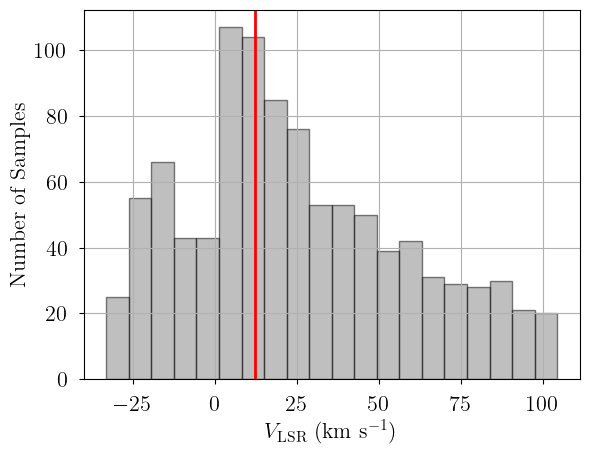

In [10]:
# plot prior predictive samples
fig, ax = plt.subplots()
ax.hist(prior.prior_predictive["vlsr"].data.flatten(), bins=20, color="gray", edgecolor="k", alpha=0.5)
ax.axvline(data["vlsr"], color="r", lw=2)
ax.set_ylabel("Number of Samples")
ax.set_xlabel(r"$V_{\rm LSR}$ (km s$^{-1}$)")

In [11]:
if not np.isnan(data["te"]):
    # plot prior predictive samples
    fig, ax = plt.subplots()
    ax.hist(np.log10(prior.prior_predictive["te"].data.flatten()), bins=20, color="gray", edgecolor="k", alpha=0.5)
    ax.axvline(np.log10(data["te"]), color="r", lw=2)
    ax.set_ylabel("Number of Samples")
    ax.set_xlabel("log$_{10}$ $T_e$ (K)")
else:
    print("Not predicting Te")

Not predicting Te


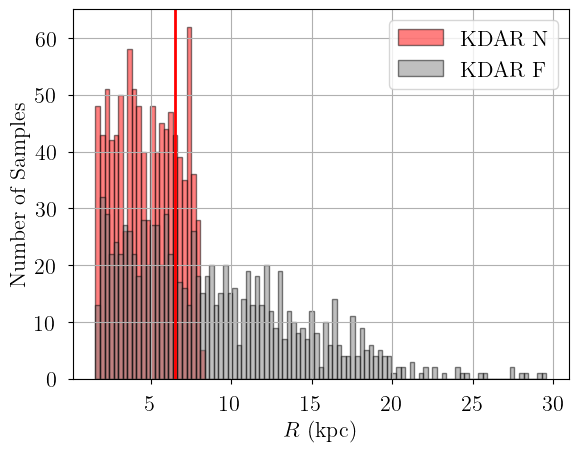

In [13]:
# plot prior samples
fig, ax = plt.subplots()
bins = np.linspace(prior.prior["Rgal"].min(), prior.prior["Rgal"].max(), 100)
if "N" in prior.prior["kdar"]:
    ax.hist(prior.prior["Rgal"].sel(kdar="N").data.flatten(), bins=bins, color="red", edgecolor="k", alpha=0.5, label="KDAR N")
ax.hist(prior.prior["Rgal"].sel(kdar="F").data.flatten(), bins=bins, color="gray", edgecolor="k", alpha=0.5, label="KDAR F")
if "Rgal" in data:
    ax.axvline(data["Rgal"], color="r", lw=2)
ax.set_ylabel("Number of Samples")
ax.set_xlabel("$R$ (kpc)")
_ = ax.legend(loc='upper right')

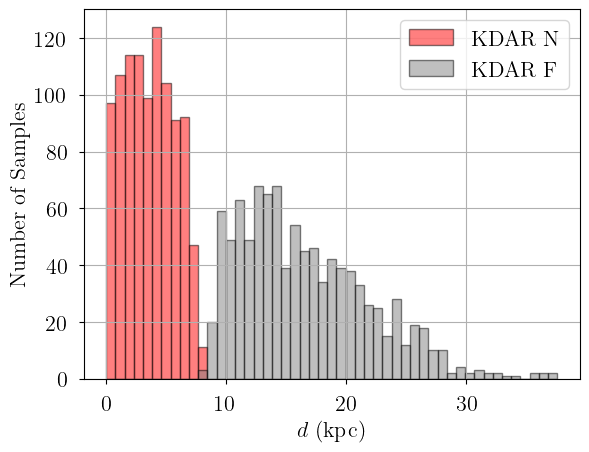

In [14]:
# plot prior samples
fig, ax = plt.subplots()
bins = np.linspace(prior.prior["distance"].min(), prior.prior["distance"].max(), 50)
if "N" in prior.prior["kdar"]:
    ax.hist(prior.prior["distance"].sel(kdar="N").data.flatten(), bins=bins, color="red", edgecolor="k", alpha=0.5, label="KDAR N")
ax.hist(prior.prior["distance"].sel(kdar="F").data.flatten(), bins=bins, color="gray", edgecolor="k", alpha=0.5, label="KDAR F")
if "distance" in data:
    ax.axvline(data["distance"], color="r", lw=2)
ax.set_ylabel("Number of Samples")
ax.set_xlabel("$d$ (kpc)")
_ = ax.legend(loc='upper right')

In [ ]:
# sample posterior dont run on macbook. run on scylla 
with my_model:
    trace = pm.sample(init="advi+adapt_diag", chains=4, cores=4, tune=1000, draws=1000, target_accept=0.85)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Output()

Convergence achieved at 17100
Interrupted at 17,099 [8%]: Average Loss = 2.7351e+05
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kdar_w, Rgal, log10_te, log10_em]


Output()

In [ ]:
 pm.summary(trace)

In [ ]:
pm.plot_trace(trace)

In [ ]:
pm.plot_pair(trace, kind="kde", var_names=["Rgal", "log10_te", "log10_em"], marginals=True)

In [ ]:
# sample posterior predictive
with my_model:
    posterior = pm.sample_posterior_predictive(trace.sel(draw=slice(None, None, 10)))

In [ ]:
# plot posteriorr predictive samples
fig, ax = plt.subplots()
ax.hist(np.log10(posterior.posterior_predictive["line"].data.flatten()), bins=20, color="gray", edgecolor="k", alpha=0.5)
ax.axvline(np.log10(data["line"]), color="r", lw=2)
ax.set_ylabel("Number of Samples")
ax.set_xlabel("log$_{10}$ Line (mJy beam$^{-1}$)")

In [ ]:
# plot prior predictive samples
fig, ax = plt.subplots()
ax.hist(posterior.posterior_predictive["vlsr"].data.flatten(), bins=20, color="gray", edgecolor="k", alpha=0.5)
ax.axvline(data["vlsr"], color="r", lw=2)
ax.set_ylabel("Number of Samples")
ax.set_xlabel(r"$V_{\rm LSR}$ (km s$^{-1}$)")

In [ ]:
if not np.isnan(data["te"]):
    # plot prior predictive samples
    fig, ax = plt.subplots()
    ax.hist(np.log10(posterior.posterior_predictive["te"].data.flatten()), bins=20, color="gray", edgecolor="k", alpha=0.5)
    ax.axvline(np.log10(data["te"]), color="r", lw=2)
    ax.set_ylabel("Number of Samples")
    ax.set_xlabel("log$_{10}$ $T_e$ (K)")

In [ ]:
# plot prior predictive samples
fig, ax = plt.subplots()
ax.hist(trace.posterior["kdar_w"].sel(kdar="F").data.flatten(), bins=20, color="gray", edgecolor="k", alpha=0.5)
ax.set_ylabel("Number of Samples")
ax.set_xlabel(r"$P_{\rm far}$")

In [ ]:
# plot prior predictive samples
fig, ax = plt.subplots()
ax.hist(trace.posterior["distance"].sel(kdar="F").data.flatten(), bins=20, color="gray", edgecolor="k", alpha=0.5)
#ax.axvline(data["distance"], color="r", lw=2)
ax.set_ylabel("Number of Samples")
ax.set_xlabel("$d$ (kpc)")